### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №3 - Дерево решений


**Общая информация**

**Срок сдачи:** 28 мая 2022, 08:30   
**Штраф за опоздание:** по 1 баллу за 24 часа задержки.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0221, Задание 3] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Реализуем дерево решений (3 балла)

Допишите недостающие части дерева решений. Ваша реализация дерева должна работать по точности не хуже DecisionTreeClassifier из sklearn.
Внимание: если Вас не устраивает предложенная структура хранения дерева, Вы без потери баллов можете сделать свой класс DecisionTreeClassifier, в котором сами полностью воспроизведете алгоритм дерева решений. Обязательно в нем иметь только функции fit, predict

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.datasets import load_wine
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier


In [2]:
import seaborn as sns

In [3]:
sns.set_style("darkgrid")

In [4]:
class MyDecisionTreeClassifier:
    NON_LEAF_TYPE = 0
    LEAF_TYPE = 1

    def __init__(self, min_samples_split=2, max_depth=5, criterion='gini'):
        """
        criterion -- критерий расщепления. необходимо релизовать три:
        Ошибка классификации, Индекс Джини, Энтропийный критерий
        max_depth -- максимальная глубина дерева
        min_samples_split -- минимальное число объектов в листе, чтобы сделать новый сплит
        """
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.num_class = -1
        # Для последнего задания
        self.feature_importances_ = None
        self.criterion = criterion
        # Структура, которая описывает дерево
        # Представляет словарь, где для  node_id (айдишник узла дерева) храним
        # (тип_узла, айдишник признака сплита, порог сплита) если тип NON_LEAF_TYPE
        # (тип_узла, предсказание класса, вероятность класса) если тип LEAF_TYPE
        # Подразумевается, что у каждого node_id в дереве слева 
        # узел с айди 2 * node_id + 1, а справа 2 * node_id + 2
        self.criterion_functions = {
            "classification_error": self.__classification_error,
            "gini": self.__gini,
            "entropy": self.__entropy
        }
        self.gain = {
            "classification_error": self.__classification_error_gain,
            "gini": self.__gini_gain,
            "entropy": self.__entropy_gain
        }
        self.__EPS = 1e-6
        self.tree = dict()

    def __classification_error(self, left, right):
        return 1 - (np.max(left) + np.max(right)) / (left.shape[0] + right.shape[0])
    
    def __gini(self, left, right):
        n = left.shape[0] + right.shape[0]
        return 1 - (np.dot(left, left) / left.shape[0] + np.dot(right, right) / right.shape[0]) / n
    
    def __entropy(self, left, right):
        n = left.shape[0] + right.shape[0]
        return - (np.dot(left, np.log(left + self.__EPS)) / left.shape[0]
                  + np.dot(right, np.log(right + self.__EPS)) / right.shape[0]) / n
    
    def __classification_error_gain(self, y):
        _, counts = np.unique(y, return_counts=True)
        return 1 - np.max(counts) / y.shape[0]
    
    def __gini_gain(self, y):
        _, counts = np.unique(y, return_counts=True)
        return 1 - np.dot(counts, counts) / (y.shape[0] * y.shape[0])
    
    def __entropy_gain(self, y):
        _, counts = np.unique(y, return_counts=True)
        return -np.dot(counts, np.log(counts + self.__EPS)) / (y.shape[0] * y.shape[0])
    
    def __div_samples(self, x, y, feature_id, threshold):
        """
        Разделяет объекты на 2 множества
        x -- матрица объектов
        y -- вектор ответов
        feature_id -- айдишник признака, по которому делаем сплит
        threshold -- порог, по которому делаем сплит
        """
        left_mask = x[:, feature_id] > threshold
        right_mask = ~left_mask
        return x[left_mask], x[right_mask], y[left_mask], y[right_mask]

    def __find_threshold(self, x, y):
        """
        Находим оптимальный признак и порог для сплита
        Здесь используемые разные impurity в зависимости от self.criterion
        """
        sorted_args = np.argsort(x)
        x_sorted = x[sorted_args]
        y_sorted = y[sorted_args]
        special_indexes = np.where(y_sorted[:-1] != y_sorted[1:])[0] + 1
        if special_indexes.shape[0] > 0:
            criterion = np.array([self.criterion_functions[self.criterion]
                             (np.bincount(y_sorted[:i], minlength=self.num_class),
                             np.bincount(y_sorted[i:], minlength=self.num_class)) 
                             for i in special_indexes])
            max_criterion_id = np.argmax(criterion)
            tmp = special_indexes[max_criterion_id]
            return criterion[max_criterion_id], (x_sorted[tmp - 1] + x_sorted[tmp]) / 2.0
        return np.array([np.inf, np.nan])
        

    def __fit_node(self, x, y, node_id, depth):
        """
        Делаем новый узел в дереве
        Решаем, терминальный он или нет
        Если нет, то строим левый узел  с айди 2 * node_id + 1
        И правый узел с  айди 2 * node_id + 2
        """
        if depth < self.max_depth and y.shape[0] >= self.min_samples_split:
            thresholds = np.array([self.__find_threshold(x[:, i], y) for i in np.arange(x.shape[1])])
            feature_id = np.argmin(thresholds[:, 0])
            threshold = thresholds[feature_id, 1]
            if not np.isnan(threshold):
                x_l, x_r, y_l, y_r = self.__div_samples(x, y, feature_id, threshold)
                if x_l.shape[0] > 0 and x_r.shape[0] > 0:
                    self.tree[node_id] = (self.__class__.NON_LEAF_TYPE, feature_id, threshold)
                    self.__update_importance(y_l, y_r, y, feature_id)
                    self.__fit_node(x_l, y_l, 2 * node_id + 1, depth + 1)
                    self.__fit_node(x_r, y_r, 2 * node_id + 2, depth + 1)
                    return
        classes_count = np.bincount(y, minlength=self.num_class)
        current_class = np.argmax(classes_count)
        self.tree[node_id] = (self.__class__.LEAF_TYPE, np.argmax(classes_count), 
                              classes_count[current_class] / classes_count.shape[0])
    
    def __update_importance(self, y_l, y_r, y, feature_id):
        self.feature_importances_[feature_id] += y.shape[0] * self.gain[self.criterion](y) \
                                                    - y_l.shape[0] * self.gain[self.criterion](y_l) \
                                                    - y_r.shape[0] * self.gain[self.criterion](y_r)
    
    def fit(self, x, y):
        """
        Рекурсивно строим дерево решений
        Начинаем с корня node_id 0
        """
        self.feature_importances_ = np.zeros(x.shape[1])
        self.num_class = np.unique(y).size
        self.__fit_node(x, y, 0, 0)
        self.feature_importances_ /= y.shape[0]

    def __predict_class(self, x, node_id):
        """
        Рекурсивно обходим дерево по всем узлам,
        пока не дойдем до терминального
        """
        node = self.tree[node_id]
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_id, threshold = node
            if x[feature_id] > threshold:
                return self.__predict_class(x, 2 * node_id + 1)
            else:
                return self.__predict_class(x, 2 * node_id + 2)
        else:
            return node[1]
        
    def predict(self, X):
        """
        Вызывает predict для всех объектов из матрицы X
        """
        return np.array([self.__predict_class(x, 0) for x in X])
    
    def fit_predict(self, x_train, y_train, predicted_x):
        self.fit(x_train, y_train)
        return self.predict(predicted_x)
    
    def get_feature_importance():
        """
        Возвращает важность признаков
        """
        return self.feature_importances_
        
    def get_params(self, deep=True):
        params = {
            "min_samples_split": self.min_samples_split,
            "max_depth": self.max_depth,
            "criterion": self.criterion
        }
        return params

In [5]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2)
clf = DecisionTreeClassifier(min_samples_split=2, max_depth=5, criterion='gini')

In [6]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

In [7]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [8]:
print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

0.9444444444444444
0.9444444444444444


## Ускоряем дерево решений (2 балла)
Добиться скорости работы на fit не медленнее чем в 10 раз sklearn на данных wine. 
Для этого используем numpy.

In [9]:
%time clf.fit(X_train, y_train)

CPU times: user 4.46 ms, sys: 63 µs, total: 4.52 ms
Wall time: 2.64 ms


DecisionTreeClassifier(max_depth=5)

In [10]:
%time my_clf.fit(X_train, y_train)

CPU times: user 36.7 ms, sys: 638 µs, total: 37.4 ms
Wall time: 33.2 ms


## Боевое применение (3 балла)

На практике Вы познакомились с датасетом Speed Dating Data. В нем каждая пара в быстрых свиданиях характеризуется определенным набором признаков. Задача -- предсказать, произойдет ли матч пары (колонка match). 

Пример работы с датасетом можете найти в практике пункт 2
https://github.com/VVVikulin/ml1.sphere/blob/master/2019-09/lecture_06/pract-trees.ipynb

Данные и описания колонок лежат тут
https://cloud.mail.ru/public/8nHV/p6J7wY1y1/speed-dating-experiment/

Скачайте датасет, обработайте данные, как показано на семинаре или своим собственным способом. Обучите дерево классифкации. В качестве таргета возьмите колонку 'match'. Постарайтесь хорошо обработать признаки, чтобы выбить максимальную точность. Если точность будет близка к случайному гаданию, задание не будет защитано. 


In [11]:
df = pd.read_csv("Speed_Dating_Data.csv", encoding="ISO-8859-1")
df = df.iloc[:, :97]

In [12]:
df.shape

(8378, 97)

In [13]:
df.sample(5)

,iid,id,gender,idg,condtn,wave,round,position,positin1,order,...,attr3_1,sinc3_1,fun3_1,intel3_1,amb3_1,attr5_1,sinc5_1,intel5_1,fun5_1,amb5_1
7740,524,16.0,0,31,2,21,22,11,11.0,20,...,5.0,9.0,7.0,8.0,7.0,5.0,9.0,9.0,7.0,7.0
3307,228,15.0,1,30,2,9,20,8,9.0,20,...,5.0,8.0,4.0,7.0,8.0,NaN,NaN,NaN,NaN,NaN
1219,87,12.0,0,23,2,4,18,9,NaN,16,...,9.0,9.0,9.0,9.0,9.0,NaN,NaN,NaN,NaN,NaN
1411,98,5.0,1,10,2,4,18,12,NaN,3,...,8.0,8.0,8.0,8.0,8.0,NaN,NaN,NaN,NaN,NaN
1343,94,1.0,1,2,2,4,18,9,NaN,13,...,6.0,9.0,9.0,9.0,7.0,NaN,NaN,NaN,NaN,NaN


#### Удалим ненужные признаки:

In [14]:
df = df.drop(['id', 'idg', 'condtn', 'round', 'position', 'positin1', 'order', 'partner', 'age_o', 'race_o',
              'pf_o_att', 'pf_o_sin', 'pf_o_int', 'pf_o_fun', 'pf_o_amb', 'pf_o_sha', 'dec_o', 'attr_o',
              'sinc_o', 'intel_o', 'fun_o', 'amb_o', 'shar_o', 'like_o', 'prob_o', 'met_o', 'field',
              'undergra', 'from', 'zipcode', 'career', 'sports', 'tvsports', 'exercise', 'dining',
              'museums', 'art', 'hiking', 'gaming', 'clubbing', 'reading', 'tv', 'theater', 'movies',
              'concerts', 'music', 'shopping', 'yoga', 'expnum', 'attr4_1', 'sinc4_1', 'intel4_1', 'fun4_1', 
              'amb4_1', 'shar4_1','attr5_1', 'sinc5_1', 'intel5_1', 'fun5_1', 'amb5_1'], axis=1)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8378 entries, 0 to 8377
Data columns (total 37 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   iid       8378 non-null   int64  
 1   gender    8378 non-null   int64  
 2   wave      8378 non-null   int64  
 3   pid       8368 non-null   float64
 4   match     8378 non-null   int64  
 5   int_corr  8220 non-null   float64
 6   samerace  8378 non-null   int64  
 7   age       8283 non-null   float64
 8   field_cd  8296 non-null   float64
 9   mn_sat    3133 non-null   object 
 10  tuition   3583 non-null   object 
 11  race      8315 non-null   float64
 12  imprace   8299 non-null   float64
 13  imprelig  8299 non-null   float64
 14  income    4279 non-null   object 
 15  goal      8299 non-null   float64
 16  date      8281 non-null   float64
 17  go_out    8299 non-null   float64
 18  career_c  8240 non-null   float64
 19  exphappy  8277 non-null   float64
 20  attr1_1   8299 non-null   floa

#### У нас осталось три нечисловых параметра, преобразуем их в числовые

In [16]:
df.loc[:, 'mn_sat'] = df.loc[:, 'mn_sat'].str.replace(',', '').astype(np.float64)
df.loc[:, 'tuition'] = df.loc[:, 'tuition'].str.replace(',', '').astype(np.float64)
df.loc[:, 'income'] = df.loc[:, 'income'].str.replace(',', '').astype(np.float64)

#### Теперь перейдем к восстановлению пропусков

Удалим те записи, где пропущена существенная информация: возраст, отношение к расе и религии партнера, как часто человек ходит на свидания
Ее мы адекватно восстановить не сможем. Пропусков данной информации немного, поэтому мы ничего не теряем

In [17]:
df = df.dropna(subset=['age', 'imprelig', 'imprace', 'date'])

Заполним пропуски там, где это возможно

In [18]:
# Для тех, у кого пропущена сфера деятельности, поставим "другое"
df.loc[:, 'field_cd'] = df.loc[:, 'field_cd'].fillna(18)
df.loc[:, 'career_c'] = df.loc[:, 'career_c'].fillna(15)
# Значение SAT заполним медианным
sat_median = np.median(np.array(df.mn_sat[df['mn_sat'].notnull()]))
df['mn_sat'] = df['mn_sat'].fillna(sat_median)
# Аналогично поступим с tuition
med = np.median(np.array(df.tuition[df['tuition'].notnull()]))
df['tuition'] = df['tuition'].fillna(med)

#### Создадим некоторые аггрегирующие признаки

In [19]:
features = ['iid', 'wave', 'attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']
tmp = df.drop_duplicates(subset=['iid', 'wave']).loc[:, features]
tmp.loc[:, 'totalsum'] = tmp.iloc[:, 2:].sum(axis=1)
df.loc[:, 'temp_totalsum'] = df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']].sum(axis=1)
df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1','shar1_1']] = (df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1',
                                     'fun1_1', 'amb1_1', 'shar1_1']].T / df.loc[:, 'temp_totalsum'].T).T * 100

In [20]:
features = ['iid', 'wave', 'attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']
tmp = df.drop_duplicates(subset=['iid', 'wave']).loc[:, features]
tmp.loc[:, 'totalsum'] = tmp.iloc[:, 2:].sum(axis=1)
df.loc[:, 'temp_totalsum'] = df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']].sum(axis=1)
df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']] = (df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1',
                                     'fun2_1', 'amb2_1', 'shar2_1']].T / df.loc[:, 'temp_totalsum'].T).T * 100

#### Наконец, закодируем категориальные признаки

In [21]:
from sklearn.preprocessing import OneHotEncoder

In [22]:
def encode(df, column):
    encoder = OneHotEncoder()
    encoded_features = encoder.fit_transform(df[column].values.reshape(-1, 1)).toarray().T
    for i in range(encoded_features.shape[0]):
        df[column + "_" + str(i + 1)] = encoded_features[i]

In [23]:
encode(df, "goal")
encode(df, "date")
encode(df, "go_out")
encode(df, "field_cd")

In [24]:
df = df.drop(['goal', 'date', 'go_out', 'field_cd'], axis=1)

#### Соберем итоговый датасет
Для этого разобьем наши данные на данные из мужчин и женщин и объединим их в пары

In [25]:
df_male = df.query("gender == 1").drop_duplicates(subset=['iid', 'pid']).drop(['gender'], axis=1).dropna()
df_female = df.query("gender == 0").drop_duplicates(subset=['iid']).drop(['gender', 'match', 'int_corr', 'samerace'], axis=1).dropna()
df_female.columns = df_female.columns + "_f"
df_female = df_female.drop(['pid_f'], axis=1)
df = df_male.join(df_female.set_index('iid_f'), on='pid', how='inner')
df = df.drop(['iid', 'pid'], axis=1)

In [26]:
df.shape

(1065, 135)

In [27]:
df.sample(5)

,wave,match,int_corr,samerace,age,mn_sat,tuition,race,imprace,imprelig,...,field_cd_9_f,field_cd_10_f,field_cd_11_f,field_cd_12_f,field_cd_13_f,field_cd_14_f,field_cd_15_f,field_cd_16_f,field_cd_17_f,field_cd_18_f
3086,9,1,0.11,0,26.0,1310.0,25020.0,2.0,8.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3264,9,0,0.26,1,23.0,1310.0,25020.0,2.0,1.0,3.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6713,17,0,0.26,1,26.0,1470.0,34300.0,2.0,5.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6843,18,0,0.50,0,33.0,1310.0,17125.0,2.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7988,21,1,-0.19,1,23.0,1210.0,23500.0,2.0,5.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
X = np.array(df.drop(['match'], axis=1))
y = np.array(df['match'])

Разбейте датасет на трейн и валидацию. Подберите на валидации оптимальный критерий  информативности. 
Постройте графики зависимости точности на валидации от глубины дерева, от минимального числа объектов для сплита. 
Какой максимальной точности удалось достигнуть?

#### Подберем критерий информативности
В качестве метрики будем использовать accuracy

In [29]:
from sklearn.model_selection import cross_val_score

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [31]:
my_clf = MyDecisionTreeClassifier(criterion="gini")
my_clf.fit(X_train, y_train)
print("Gini: ", np.mean(cross_val_score(my_clf, X_train, y_train, cv=3, scoring="accuracy")))

Gini:  0.7981220657276995


In [32]:
my_clf = MyDecisionTreeClassifier(criterion="entropy")
my_clf.fit(X_train, y_train)
print("Entropy: ", np.mean(cross_val_score(my_clf, X_train, y_train, cv=3, scoring="accuracy")))

Entropy:  0.7887323943661971


In [33]:
my_clf = MyDecisionTreeClassifier(criterion="classification_error")
my_clf.fit(X_train, y_train)
print("Classification error: ", np.mean(cross_val_score(my_clf, X_train, y_train, cv=3, scoring="accuracy")))

Classification error:  0.8192488262910799


Итак, наибольшая точность оказалась при использовании ошибки классификации

In [34]:
depths = np.arange(1, 20)
accuracies = []
for depth in depths:
    my_clf = MyDecisionTreeClassifier(criterion="classification_error", max_depth=depth)
    accuracies.append(np.mean(cross_val_score(my_clf, X_train, y_train, cv=3, scoring="accuracy")))

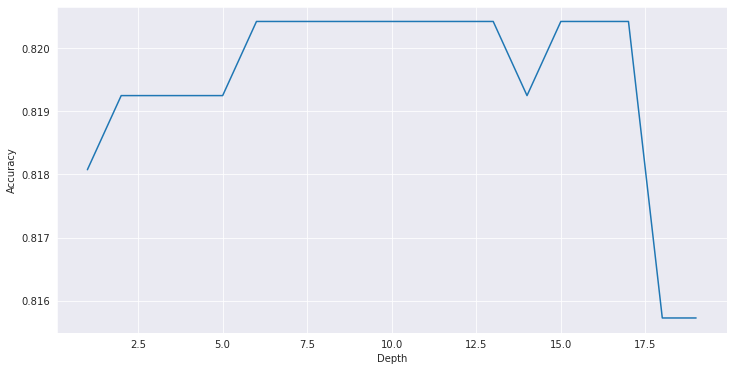

In [35]:
plt.figure(figsize=(12,6))
plt.plot(depths, accuracies)
plt.ylabel("Accuracy")
plt.xlabel("Depth")
plt.show()

Лучшая глубина - 7

In [36]:
samples = np.arange(5, 30)
accuracies = []
for sample in samples:
    my_clf = MyDecisionTreeClassifier(criterion="classification_error", min_samples_split=sample, max_depth=7)
    accuracies.append(np.mean(cross_val_score(my_clf, X_train, y_train, cv=3, scoring="accuracy")))

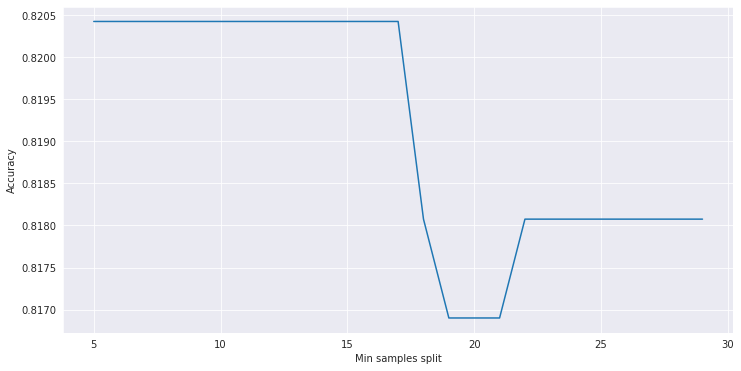

In [37]:
plt.figure(figsize=(12,6))
plt.plot(samples, accuracies)
plt.ylabel("Accuracy")
plt.xlabel("Min samples split")
plt.show()

Оптимальное значение min_samles_split - 10

Обучим нашу модель с лучшими параметрами и найдем точность на валидации и тестовой выборке

In [38]:
my_clf = MyDecisionTreeClassifier(criterion="classification_error", min_samples_split=10, max_depth=7)
print("Validation score: ", np.mean(cross_val_score(my_clf, X_train, y_train, cv=3, scoring="accuracy")))

Validation score:  0.8204225352112676


In [39]:
my_clf = MyDecisionTreeClassifier(criterion="classification_error", min_samples_split=10, max_depth=7)
my_clf.fit(X_train, y_train)
print("Test score: ", accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

Test score:  0.8169014084507042


## Находим самые важные признаки (2 балла)



По построенному дереву  легко понять, какие признаки лучше всего помогли решить задачу. Часто это бывает нужно  не только  для сокращения размерности в данных, но и для лучшего понимания прикладной задачи. Например, Вы хотите понять, какие признаки стоит еще конструировать -- для этого нужно понимать, какие из текущих лучше всего работают в дереве. 

Самый простой метод -- посчитать число сплитов, где использовался данные признак. Это не лучший вариант, так как по признаку который принимает всего 2 значения, но который почти точно разделяет выборку, число сплитов будет очень 1, но при этом признак сам очень хороший. 
В этом задании предлагается для каждого признака считать суммарный gain (в лекции обозначено как Q) при использовании этого признака в сплите. Тогда даже у очень хороших признаков с маленьким число сплитов это значение должно быть довольно высоким.  

Реализовать это довольно просто: создаете словарь номер фичи : суммарный гейн и добавляете в нужную фичу каждый раз, когда используете ее при построении дерева. 

Добавьте функционал, который определяет значения feature importance. Обучите дерево на датасете Speed Dating Data.
Выведите 10 главных фичей по важности.

In [42]:
my_clf = MyDecisionTreeClassifier(criterion="gini", min_samples_split=10, max_depth=7)
my_clf.fit(X_train, y_train)

In [43]:
print(pd.Series(data=my_clf.feature_importances_, 
        index=df.columns[1:]).sort_values(ascending=False)[:10])

attr1_1         0.009649
match           0.005444
field_cd_10     0.004663
field_cd_4_f    0.004307
income          0.004108
amb2_1_f        0.003537
field_cd_8      0.003386
amb2_1          0.003144
go_out_1        0.003040
intel2_1_f      0.002999
dtype: float64


## Фидбек (бесценно)

* Какие аспекты обучения деревьев решений Вам показались непонятными? Какое место стоит дополнительно объяснить?

Было бы круто иметь список подсказок (может, за небольшую потерю баллов), как ускорять реализацию дерева, потому что вроде все уже вроде на нампае, а все еще медленно

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

Курс классный, домшка объемная, сложная, работать было интересно. Возможно, стоило дать другой датасет для предобработки, в идеале, на выбор, чтобы студентам было можно рабоать с теми данными, которые интересны студентам